In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats # For hypothesis testing

# Load the two main datasets. 
# TMDB dataset (Contains plots, budget, revenue, and genres)
tmdb_df = pd.read_csv('datasets\TMDB_movie_dataset_v11.csv') 

# Rotten Tomatoes dataset (Contains ratings and critic/audience scores)
rt_df = pd.read_csv('datasets\Rotten Tomatoes Movies.csv')

Dataset Inspection

In [4]:
print(tmdb_df.info())
print("\nFirst 5 rows:")
print(tmdb_df.head())
print("\nColumns and Data Types:")
print(tmdb_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310527 entries, 0 to 1310526
Data columns (total 24 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1310527 non-null  int64  
 1   title                 1310511 non-null  object 
 2   vote_average          1310527 non-null  float64
 3   vote_count            1310527 non-null  int64  
 4   status                1310527 non-null  object 
 5   release_date          1047284 non-null  object 
 6   revenue               1310527 non-null  int64  
 7   runtime               1310527 non-null  int64  
 8   adult                 1310527 non-null  bool   
 9   backdrop_path         334220 non-null   object 
 10  budget                1310527 non-null  int64  
 11  homepage              136170 non-null   object 
 12  imdb_id               643732 non-null   object 
 13  original_language     1310527 non-null  object 
 14  original_title        1310511 non-

In [5]:
# Rotten Tomatoes Dataset
print("\nFirst 5 rows:")
print(rt_df.head())
print("\nColumns and Data Types:")
print(rt_df.info())


First 5 rows:
                                         movie_title  \
0  Percy Jackson & the Olympians: The Lightning T...   
1                                        Please Give   
2                                                 10   
3                    12 Angry Men (Twelve Angry Men)   
4                       20,000 Leagues Under The Sea   

                                          movie_info  \
0  A teenager discovers he's the descendant of a ...   
1  Kate has a lot on her mind. There's the ethics...   
2  Blake Edwards' 10 stars Dudley Moore as George...   
3  A Puerto Rican youth is on trial for murder, a...   
4  This 1954 Disney version of Jules Verne's 20,0...   

                                   critics_consensus rating  \
0  Though it may seem like just another Harry Pot...     PG   
1  Nicole Holofcener's newest might seem slight i...      R   
2                                                NaN      R   
3  Sidney Lumet's feature debut is a superbly wri...     NR

Data Cleaning and Parsing

In [6]:
# 1.TMDB Data (tmdb_df) Preparation
# Selecting only relevant columns
tmdb_cols = ['id', 'title', 'release_date', 'budget', 'revenue', 'runtime', 
             'vote_average', 'vote_count', 'overview', 'genres']
tmdb_df_clean = tmdb_df[tmdb_cols].copy()

# Convert list-like string columns (genres) to usable strings
tmdb_df_clean['title'] = tmdb_df_clean['title'].str.strip()

# Handle missing numerical data in TMDB
# Keep existing 0s but drop NaN release dates
tmdb_df_clean.dropna(subset=['release_date'], inplace=True)

# 2. Rotten Tomatoes Data (rt_df) Preparation
rt_cols = ['movie_title', 'in_theaters_date', 'tomatometer_rating', 'audience_rating', 
           'tomatometer_count', 'audience_count', 'genre']
rt_df_clean = rt_df[rt_cols].copy()

# Rename columns to match TMDB dataset for easy merging/clarity
rt_df_clean.rename(columns={'movie_title': 'title', 
                            'in_theaters_date': 'release_date',
                            'genre': 'rt_genre'}, 
                  inplace=True)
rt_df_clean['title'] = rt_df_clean['title'].str.strip()

# Handle missing audience ratings in RT data
rt_df_clean.dropna(subset=['audience_rating', 'audience_count'], inplace=True)
 
print("TMDB Cleaned Shape:", tmdb_df_clean.shape)
print("RT Cleaned Shape:", rt_df_clean.shape)

TMDB Cleaned Shape: (1047284, 10)
RT Cleaned Shape: (16386, 7)


Organize & Merge DataFrames

In [7]:

# 1. Merge on 'title' and 'release_date'
tmdb_df_clean['release_date'] = tmdb_df_clean['release_date'].astype(str)
rt_df_clean['release_date'] = rt_df_clean['release_date'].astype(str)

merged_df = pd.merge(tmdb_df_clean, rt_df_clean, 
                     on=['title', 'release_date'], 
                     how='inner')

# 2. Calculate a Profit for analysis and hypothesis testing later
merged_df['profit'] = merged_df['revenue'] - merged_df['budget']

# Convert release date back to datetime obj for analysis
merged_df['release_date'] = pd.to_datetime(merged_df['release_date'], errors='coerce')
merged_df.dropna(subset=['release_date'], inplace=True)

print("\nMerged Dataset Head:")
print(merged_df[['title', 'budget', 'revenue', 'profit', 'vote_average', 'tomatometer_rating', 'audience_rating']].head())
print("\nMerged Dataset Final Shape (Entries, Features):", merged_df.shape)


Merged Dataset Head:
                                title     budget    revenue     profit  \
0                          Fight Club   63000000  100853753   37853753   
1                    Django Unchained  100000000  425368238  325368238   
2             The Wolf of Wall Street  100000000  392000000  292000000   
3  Captain America: The First Avenger  140000000  370569774  230569774   
4                  Back to the Future   19000000  381109762  362109762   

   vote_average  tomatometer_rating  audience_rating  
0         8.438                  79             96.0  
1         8.171                  86             91.0  
2         8.035                  79             82.0  
3         6.995                  80             74.0  
4         8.314                  96             94.0  

Merged Dataset Final Shape (Entries, Features): (5204, 16)


Conclusion 1: Dataset Charcteristics 
- general scope
- central tendencies
- most frequent vales of combined data

Satistical Method: Descriptive statistics

Hypothesis:
"The majority of high-budget films are concentrated in the Action/Adventure genres, but the average profit margin is highly volatile."


--- Financial Feature Descriptive Statistics ---
          count          mean           std         min  25%       50%  \
budget   5204.0  1.244467e+07  2.331925e+07         0.0  0.0  250000.0   
revenue  5204.0  2.984927e+07  7.476859e+07         0.0  0.0  536693.5   
profit   5204.0  1.740460e+07  6.162396e+07 -92896027.0  0.0       0.0   

                75%           max  
budget   16000000.0  2.700000e+08  
revenue  25226313.0  1.310466e+09  
profit   10641590.0  1.140466e+09  


C:\Users\saads\AppData\Local\Temp\ipykernel_5180\1165231751.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.index, y=top_genres.values, palette="viridis")


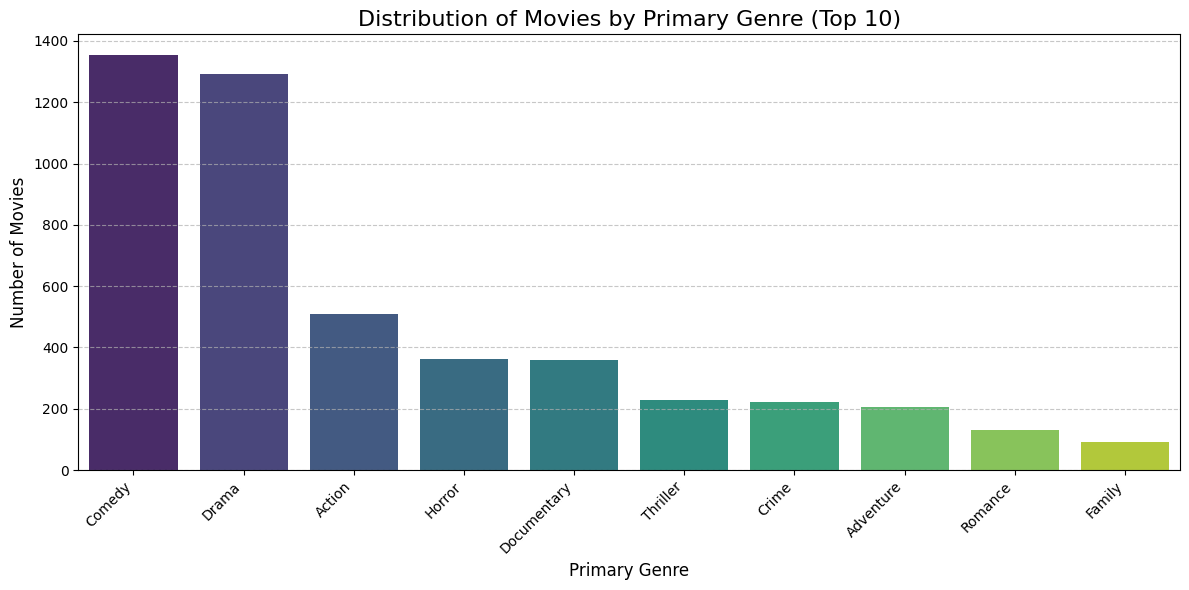

In [ ]:
# Descriptive Statistics and Genre Frequency

# Calculate descriptive statistics for key financial features
print("Financial Feature Descriptive Statistics:")
print(merged_df[['budget', 'revenue', 'profit']].describe().T)

# Prepare data for plot: Count primary genre occurrences
# Extract the first genre for simpler visualization
def get_primary_genre(genre_str):
    if pd.isna(genre_str): return 'Unknown'
    return genre_str.split(',')[0].strip()

merged_df['primary_genre'] = merged_df['genres'].apply(get_primary_genre)

top_genres = merged_df['primary_genre'].value_counts().head(10)

# Plot: Bar chart of Top 10 Genres
plt.figure(figsize=(12, 6))
sns.barplot(x=top_genres.index, y=top_genres.values, palette="viridis")
plt.title('Distribution of Movies by Primary Genre (Top 10)', fontsize=16)
plt.xlabel('Primary Genre', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



Conclusion 1 Result: The merged dataset shows two critical characteristics that influence the analysis: 

- Financial skewness and genre imbalance. 
- The financial features display a significant right-skew, highlisghted by the mean revenue ($29.8 million) far exceeding the median ($536,693.5) and a high count of zero-value profits. 
- This vast difference confirms the presence of extreme financial outliers (blockbusters), which suggests a non-normal distribution.
- The primary genre distribution reveals a strong imbalance, with Comedy and Drama films being heavily over-represented. This imbalance will need to be addressed eventually to prevent biasing toward majority classes.

Conlusion 2: Correlation Analysis
- Test inital hypothesis: "Does a movie's budget have a significant effect on its user ratings?"

Statistical Method: Correlation Coefficient. 

- Hypothesis: "Movie budget has a weak positive correlation with audience and critic ratings, suggesting that a large financial investment does not guarantee high critical praise."

Correlation (Budget vs. Audience Rating): -0.04
Correlation (Budget vs. Tomatometer Rating): -0.13


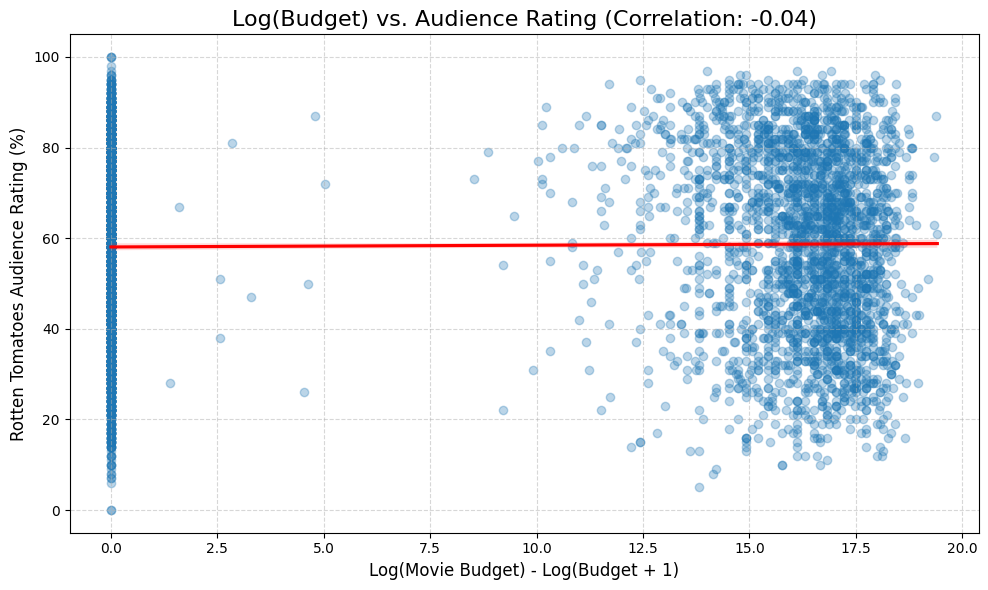

In [ ]:
# Calculate correlation between financial metrics and ratings
budget_audience_corr = merged_df['budget'].corr(merged_df['audience_rating'])
budget_tomatometer_corr = merged_df['budget'].corr(merged_df['tomatometer_rating'])

print(f"Correlation (Budget vs. Audience Rating): {budget_audience_corr:.2f}")
print(f"Correlation (Budget vs. Tomatometer Rating): {budget_tomatometer_corr:.2f}")

# Plot: Scatter Plot of Budget vs. Audience Rating
plt.figure(figsize=(10, 6))

# log scale for budget to handle variance and make the plot more gorgeous
sns.regplot(x=np.log1p(merged_df['budget']), y=merged_df['audience_rating'], 
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Log(Budget) vs. Audience Rating (Correlation: {:.2f})'.format(budget_audience_corr), fontsize=16)
plt.xlabel('Log(Movie Budget) - Log(Budget + 1)', fontsize=12)
plt.ylabel('Rotten Tomatoes Audience Rating (%)', fontsize=12)
plt.grid(axis='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Conclusion 2 Result: 

After applying Pearson Correlation Coefficient method to test the hypothesis that movie budget significantly affects audience ratings.The analysis yielded a correlation of -0.04 between the logarithm of the budget and the Rotten Tomatoes Audience Rating. The plot visually supports this finding, showing the regression line is nearly flat, indicating no linear relationship between a movie's budget and its audience score. The data points are widely scattered across the entire range of ratings for almost all budget levels, emphasizing that financial investment is not a reliable predictor of audience approval. This confirms that budget is not an attribute that will directly affect the choice of primary analysis technique for predicting audience success.

Conclusion 3: 
- Test 2nd initial hypothesis: "Is there a statistically significant difference in revenue between Action and Drama movies?" 

Statistical Method: Two-sample Independent T-test. 

Hypothesis: 
- "The difference in average revenue between Action and Drama movies is statistically significant, with Action films generating significantly higher revenue."
- Null Hypothesis: Average revennues are equal
- Alt. Hypothesis: Average revenues are not equal

Mean Revenue - Action: $82,179,374
Mean Revenue - Drama: $44,252,251
T-statistic: 6.80
P-value: 0.0000000000


C:\Users\saads\AppData\Local\Temp\ipykernel_5180\2329482043.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Genre', y=np.log1p(plot_df['Revenue']), data=plot_df, palette=['lightcoral', 'skyblue'])


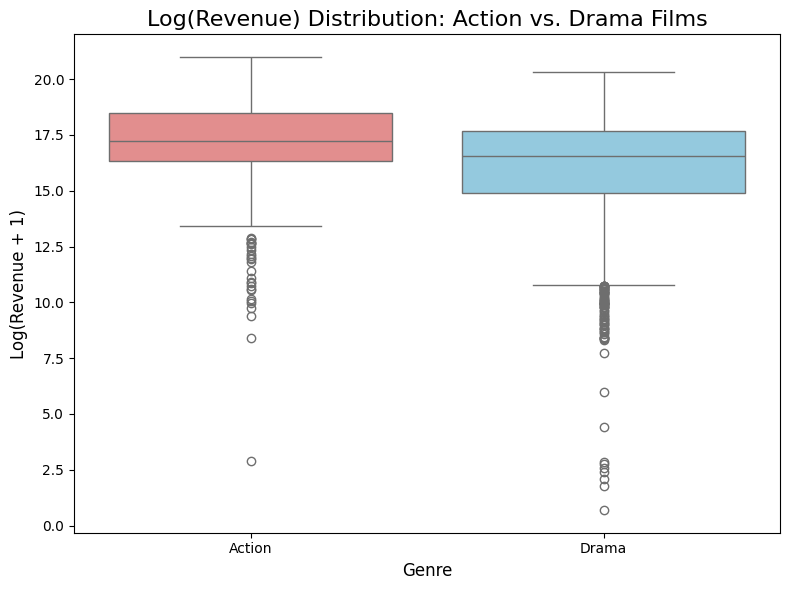

In [10]:
# Method 3: Hypothesis Testing (Two-Sample T-test):

# Filter revenue data for Action and Drama movies
# Use TMDB 'genres' column to identify movies containing specific genre str
action_revenue = merged_df[merged_df['genres'].str.contains('Action', na=False)]['revenue']
drama_revenue = merged_df[merged_df['genres'].str.contains('Drama', na=False)]['revenue']

# Filter out 0 revenue entries bc missing data may skew results
action_revenue = action_revenue[action_revenue > 0]
drama_revenue = drama_revenue[drama_revenue > 0]

# T-test
t_stat, p_value = stats.ttest_ind(action_revenue, drama_revenue, equal_var=False) # Use False for Welch's t-test

print(f"Mean Revenue - Action: ${action_revenue.mean():,.0f}")
print(f"Mean Revenue - Drama: ${drama_revenue.mean():,.0f}")
print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_value:.10f}") # Print p-value with high precision

# Plot: Box Plot of Revenue by Genre
plot_df = pd.DataFrame({
    'Revenue': pd.concat([action_revenue, drama_revenue]),
    'Genre': ['Action'] * len(action_revenue) + ['Drama'] * len(drama_revenue)
})

plt.figure(figsize=(8, 6))
# Box plot to show distribution, log scale to visualize variance
sns.boxplot(x='Genre', y=np.log1p(plot_df['Revenue']), data=plot_df, palette=['lightcoral', 'skyblue'])
plt.title('Log(Revenue) Distribution: Action vs. Drama Films', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Log(Revenue + 1)', fontsize=12)
plt.tight_layout()
plt.show()


Conclusion 3 Result: 

After a Two-Sample T-test to determine if there is a statistically significant difference in revenue between Action and Drama films, using revenue data, the analysis suggests rejecting the null hypothesis (that average revenues are equal) as the P-value is 0. The mean revenue for Action films ($82.18 million) is nearly double that of Drama films ($44.25 million). The box plot visually supports this significant difference, showing that while both genres have high-revenue outliers, the overall distribution and upper quartile for Action films are substantially higher than for Drama films. This confirms that genre is a highly influential attribute for revenue.